### DOMAIN: Semiconductor manufacturing process
### CONTEXT:
A complex modern semiconductor manufacturing process is normally under constant surveillance via the monitoring of signals/ variables collected from sensors and or process measurement points. However, not all of these signals are equally valuable in a specific monitoring system. The measured signals contain a combination of useful information, irrelevant information as well as noise. Engineers typically have a much larger number of signals than are actually required. If we consider each type of signal as a feature, then feature selection may be applied to identify the most relevant signals. The Process Engineers may then use these signals to determine key factors contributing to yield excursions downstream in the process. This will enable an increase in process throughput, decreased time to learning and reduce the per unit production costs. These signals can be used as features to predict the yield type. And by analysing and trying out different combinations of features, essential signals that are impacting the yield type can be identified.

### DATA DESCRIPTION: sensor-data.csv : (1567, 592)
The data consists of 1567 examples each with 591 features. The dataset presented in this case represents a selection of such features where each example represents a single production entity with associated measured features and the labels represent a simple pass/fail yield for in house line testing. Target column “ –1” corresponds to a pass and “1” corresponds to a fail and the data time stamp is for that specific test point.

### PROJECT OBJECTIVE:
We will build a classifier to predict the Pass/Fail yield of a particular process entity and analyse whether all the features are required to build the model or not.



### Step 1: import libraries

In [1]:
import pandas as pd
import numpy as np
import pathlib
from numpy import unique
from datetime import datetime

#visulizations
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.model_selection import LearningCurve
%matplotlib inline

from scipy import stats
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA 
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score,cross_val_predict,cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pylab as pl

#display options
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('float_format', '{:.3f}'.format)

import warnings
warnings.filterwarnings("ignore")

### step 1.1 Functions

In [2]:
def data_understand(filename):
    file = pathlib.Path(filename)
    if file.exists ():
        print ("File exist")
        print('*****************************')
        data_out=pd.read_csv(filename)
        print('ínformation of data')
        print(data_out.dtypes)
        print('*****************************')
        print('Sample data')
        print(data_out.head())
    else:
        print ("File does not exist")
    return data_out   

def col_elimination(data,mis_list1,mis_list2,zero_var_cl):
    data=data.drop(['Pass/Fail', 'Time'], axis=1)
    for i in data.columns:
        mis_percent=data[i].isnull().mean()*100
        if mis_percent < 40 :
            mis_list1.append(i)   
        elif mis_percent >40 :
            mis_list2.append(i)
        if data[i].dtype=='int64' or data[i].dtype=='float64':
            if  round(data[i].std())==0:
                zero_var_cl.append(i)
    print("number of columns with missing percent at most 40",len(mis_list1))
    print("number of columns with missing percent at greater 40",len(mis_list2)) 
    print("number of columns with zero variance",len(zero_var_cl))
    return zero_var_cl,mis_list2

In [3]:
# #checking for available performance metrics
# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())

### Step 2: Understand data

In [4]:
#understand data
data_in=data_understand('signal-data.csv')
print(data_in.shape)

File exist
*****************************
ínformation of data
Time          object
0            float64
1            float64
2            float64
3            float64
              ...   
586          float64
587          float64
588          float64
589          float64
Pass/Fail      int64
Length: 592, dtype: object
*****************************
Sample data
                  Time        0        1        2        3     4       5  \
0  2008-07-19 11:55:00 3030.930 2564.000 2187.733 1411.127 1.360 100.000   
1  2008-07-19 12:32:00 3095.780 2465.140 2230.422 1463.661 0.829 100.000   
2  2008-07-19 13:17:00 2932.610 2559.940 2186.411 1698.017 1.510 100.000   
3  2008-07-19 14:43:00 2988.720 2479.900 2199.033  909.793 1.320 100.000   
4  2008-07-19 15:22:00 3032.240 2502.870 2233.367 1326.520 1.533 100.000   

        6     7     8      9     10    11      12    13     14      15     16  \
0  97.613 0.124 1.500  0.016 -0.003 0.946 202.440 0.000  7.956 414.871 10.043   
1 102.343 0.125 1.49

Summary:
1. All variables are float except time and Pass/Fail ( target variable)
2. From sample data it looks like some variables have constant values. These variables will not add to any information/variation for target. So these variables need to be identified and removed

In [5]:
data_in.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,Pass/Fail
count,1561.000,1560.000,1553.000,1553.000,1553.000,1553.000,1553.000,1558.000,1565.000,1565.000,1565.000,1565.000,1565.000,1564.000,1564.000,1564.000,1564.000,1564.000,1564.000,1557.000,1567.000,1565.000,1565.000,1565.000,1565.000,1565.000,1565.000,1565.000,1565.000,1565.000,1565.000,1565.000,1566.000,1566.000,1566.000,1566.000,1566.000,1566.000,1566.000,1566.000,1543.000,1543.000,1566.000,1566.000,1566.000,1566.000,1566.000,1566.000,1566.000,1566.000,1566.000,1566.000,1566.000,1563.000,1563.000,1563.000,1563.000,1563.000,1563.000,1560.000,1561.000,1561.000,1561.000,1560.000,1560.000,1560.000,1561.000,1561.000,1561.000,1561.000,1561.000,1561.000,773.000,773.000,1561.000,1543.000,1543.000,1543.000,1543.000,1543.000,1543.000,1543.000,1543.000,1566.000,1555.000,226.000,1567.000,1567.000,1567.000,1516.000,1516.000,1561.000,1565.000,1565.000,1561.000,1561.000,1561.000,1561.000,1561.000,1561.000,1561.000,1561.000,1561.000,1565.000,1565.000,1561.000,1561.000,1561.000,1561.000,549.000,549.000,549.000,852.000,1567.000,1567.000,1567.000,1567.000,1567.000,1543.000,1567.000,1567.000,1558.000,1558.000,1558.000,1558.000,1558.000,1558.000,1558.000,1558.000,1558.000,1558.000,1558.000,1559.000,1559.000,1559.000,1562.000,1561.000,1560.000,1553.000,1553.000,1553.000,1553.000,1553.000,1558.000,1565.000,1565.000,1565.000,1565.000,1565.000,1564.000,1564.000,1564.000,1564.000,1564.000,1564.000,1557.000,1567.000,138.000,138.000,1565.000,1565.000,1565.000,1565.000,1565.000,1565.000,1565.000,1565.000,1565.000,1565.000,1565.000,1566.000,1566.000,1566.000,1566.000,1566.000,1566.000,1566.000,1566.000,1543.000,1566.000,1566.000,1566.000,1566.000,1566.000,1566.000,1566.000,1566.000,1566.000,1566.000,1566.000,1563.000,1563.000,1563.000,1563.000,1563.000,1563.000,1560.000,1561.000,1561.000,1561.000,1560.000,1560.000,1560.000,1561.000,1561.000,1561.000,1561.000,1561.000,1561.000,1561.000,1543.000,1543.000,1543.000,1543.000,1543.000,1543.000,1543.000,1543.000,1566.000,1555.000,226.000,1567.000,1567.000,1567.000,1516.000,1516.000,1561.000,1565.000,1565.000,1561.000,1561.000,1561.000,1561.000,1561.0

In [6]:
#for EDA converting target to object
data_eda=data_in.copy()
data_eda['Pass/Fail']=data_eda['Pass/Fail'].astype('object')
data_eda['Pass/Fail'].value_counts(normalize=True)

-1   0.934
 1   0.066
Name: Pass/Fail, dtype: float64

In [7]:
data_in1=data_in.dropna(how='all')
data_in1.shape
#no row with all missing 

(1567, 592)

Summary
1. Data has variables with zero standard deviations.
2. max value of various variables are very distinct from 75% percentile. Showing skeness in data.
3. Target varible is imbalanced

### Step 2.1: identify variables with low variance and high percentagge of missing value

In [8]:
#getting a list of columns which has missing data more than 40% and zero variance
mis_list, zero_var_list=col_elimination(data_in,[],[],[])

#dropping columns which has zero variance and missing data
drop_cl_list=zero_var_list+mis_list
drop_cl_list_fl=list(set(drop_cl_list))
data_sub1= data_in.drop(labels=drop_cl_list_fl, axis=1)
print("Shape of data after removal redundant data",data_sub1.shape)

number of columns with missing percent at most 40 558
number of columns with missing percent at greater 40 32
number of columns with zero variance 328
Shape of data after removal redundant data (1567, 246)


In [9]:
#drop_cl_list_fl

In [10]:
data_sub_skew= data_sub1.drop(['Pass/Fail','Time'], axis=1)
data_char= data_sub1[['Pass/Fail','Time']]
df=pd.DataFrame()
Q1 = data_sub_skew.quantile(0.25)
Q3 = data_sub_skew.quantile(0.75)
IQR = Q3 - Q1
# print(IQR)
for i in data_sub_skew.columns:
    IQR=data_sub_skew[i].quantile(0.75)-data_sub_skew[i].quantile(0.25)
    upper_out=data_sub_skew[i].quantile(0.75)+1.5*IQR
    lower_out=data_sub_skew[i].quantile(0.25)-1.5*IQR
    data_sub_skew[i]=np.where(((data_sub_skew[i]>upper_out)|(data_sub_skew[i]<lower_out)),np.nan,data_sub_skew[i])
data_v1= pd.concat([data_sub_skew,data_char], axis=1)

In [11]:
data_v1.shape

(1567, 246)

### Step 2.2: data exploration

<AxesSubplot:>

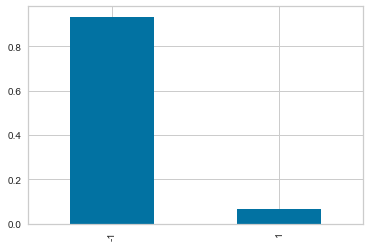

In [12]:
data_v1['Pass/Fail'].value_counts(normalize=True).plot(kind='bar')

### Step 2.3: Checking for skewness

In [13]:
#Checking for skewness
feature=[]
skewness=[]
data_sub_skew= data_v1.drop(['Time','Pass/Fail'], axis=1)
for i in data_sub_skew.columns:
    val=data_sub_skew[i].skew(axis = 0,skipna = True)
    feature.append(i)
    skewness.append(val)

data_skew=pd.DataFrame({'feature':feature,
                        'skewness':skewness
                       })
def skew_con(row):
    val=row['skewness']
    if val < -1.0 or val > 1.0:
        val_des='Feature is highly skewed'
    elif (val > -1.0 and val <-0.5) or (val < 1.0 and val >0.5):
        val_des='Feature is moderatly skewed'
    elif val > -0.5 or val < 0.5:
        val_des='Feature is approximately symmetric'
    return val_des

data_skew['Interpretation'] = data_skew.apply(skew_con,axis=1)

In [14]:
print('Summary of skewness')
data_skew['Interpretation'].value_counts(normalize=True)

Summary of skewness


Feature is approximately symmetric   0.590
Feature is moderatly skewed          0.336
Feature is highly skewed             0.074
Name: Interpretation, dtype: float64

### Step 2.4 : Directional approach for variable importance

In [15]:
data_skew_t_test= data_v1.drop(['Time'], axis=1)
var=[]
p_val=[]
result=[]

for i in data_skew_t_test.columns:
    gr1=data_skew_t_test[data_skew_t_test['Pass/Fail']==-1]
    gr2=data_skew_t_test[data_skew_t_test['Pass/Fail']==1]
    group1=gr1[i]
    group2=gr2[i]
    u_statistic, p_value = stats.mannwhitneyu(group1, group2)    
    var.append(i)
    p_val.append(p_value)
    if  p_value < 0.05:
        res=1
    else:
        res=0
    result.append(res)
    
df_var_significant_test=pd.DataFrame({'variable':var,'p_value':p_val,'result':result})

df_var_significant_test.shape
df_var_significant=df_var_significant_test[df_var_significant_test['result']==1]
df_var_significant.shape
df_var_significant.head(7)
var_sig=list(df_var_significant['variable'])
print('Number of significant variables based on group mean are', len(var_sig), 'from total variables',data_in.shape[1])

Number of significant variables based on group mean are 59 from total variables 592


In [16]:
var_sig.remove('Pass/Fail')

In [17]:
len(var_sig)

58

In [18]:
# var_sig

Summary :
1. Data Has variables with lot of missing data.
2. Data has skew variables.
3. columns shows multicolinearity.
4. variables with missing data more than 60% have been removed.
6. outliers have been marked as np.nan, which will be imputed later

### Step 2.5 : validating test results with sample visulization

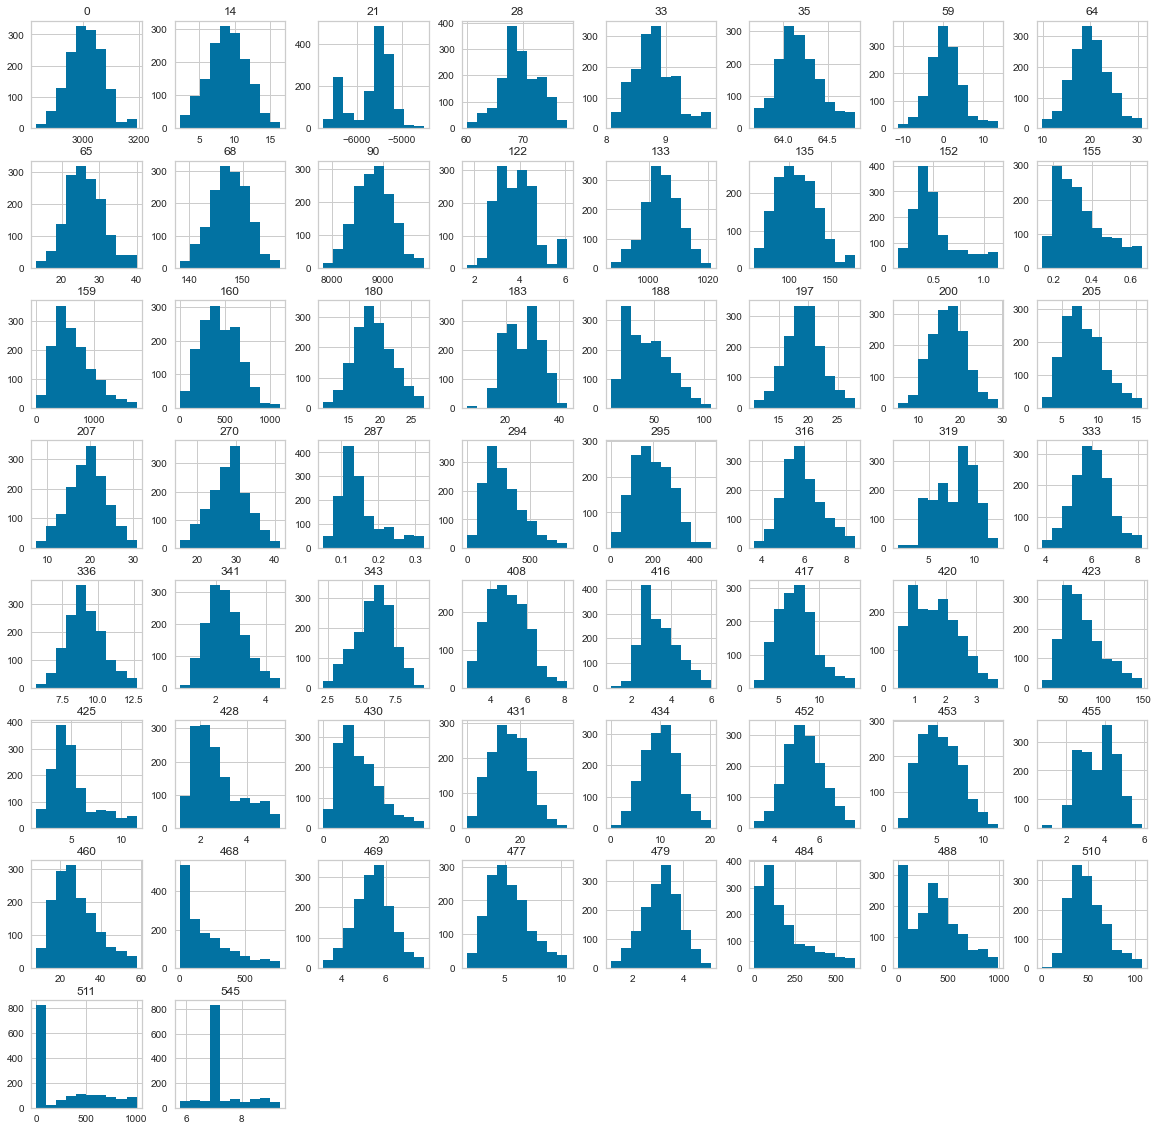

In [19]:
dataset=data_v1[var_sig]
dataset.hist(figsize=(20,20))
plt.show()

In [20]:
# dataset['Pass/Fail']=dataset['Pass/Fail'].astype('object')
# df=dataset.groupby('Pass/Fail')
# df1=dataset.boxplot(by='Pass/Fail',figsize=(20,20))

Text(0.5, 1.0, 'Distribution of 2')

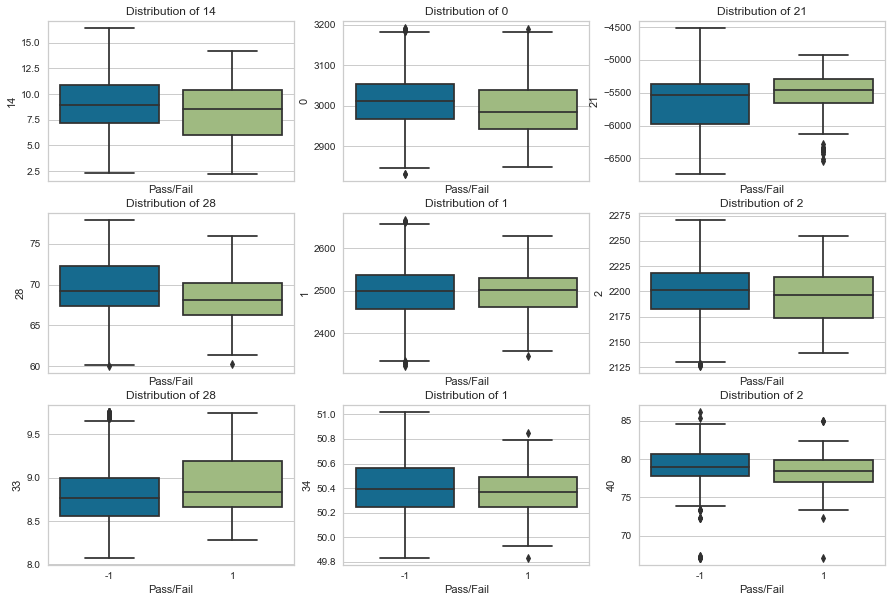

In [21]:
f, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)
sns.boxplot(data_v1['Pass/Fail'],data_v1['14'],ax=axes[0,0]).set_title('Distribution of 14')
sns.boxplot(data_v1['Pass/Fail'],data_v1['0'],ax=axes[0,1]).set_title('Distribution of 0')
sns.boxplot(data_v1['Pass/Fail'],data_v1['21'],ax=axes[0,2]).set_title('Distribution of 21')
sns.boxplot(data_v1['Pass/Fail'],data_v1['28'],ax=axes[1,0]).set_title('Distribution of 28')
sns.boxplot(data_v1['Pass/Fail'],data_v1['1'],ax=axes[1,1]).set_title('Distribution of 1')
sns.boxplot(data_v1['Pass/Fail'],data_v1['2'],ax=axes[1,2]).set_title('Distribution of 2')
sns.boxplot(data_v1['Pass/Fail'],data_v1['33'],ax=axes[2,0]).set_title('Distribution of 28')
sns.boxplot(data_v1['Pass/Fail'],data_v1['34'],ax=axes[2,1]).set_title('Distribution of 1')
sns.boxplot(data_v1['Pass/Fail'],data_v1['40'],ax=axes[2,2]).set_title('Distribution of 2')

Summary:
1. From Sample visulization, variables which have shown significant impact in group mean of target also shows different distribution across taget class

### Step 2.6 : Correlation

In [22]:
var1=[]
var2=[]
corelation=[]
data_sub_skew= data_v1.drop(['Pass/Fail','Time'], axis=1)
for i in data_sub_skew.columns:
    for j in data_sub_skew.columns:
        if i== j:
            pass
        else:
            data_sub_skew[i]=data_sub_skew[i].astype('float64')
            data_sub_skew[j]=data_sub_skew[j].astype('float64')
            corr=data_sub_skew[i].corr(data_sub_skew[j])
            if (corr > 0.6) or (corr < -0.6) :
                var1.append(i)
                var2.append(j)
                corelation.append(corr)
df_cor= pd.DataFrame({'signal1': var1,'signal2': var2, 'corelation':corelation})      

In [23]:
df_cor.head(10)

,signal1,signal2,corelation
0,12,18,0.981
1,18,12,0.981
2,21,27,0.750
3,21,440,0.641
4,27,21,0.750
5,27,440,0.745
6,34,36,-1.000
7,36,34,-1.000
8,43,50,0.642
9,43,60,0.932


Summary: Data has multicolinrarity

### Step 2.7 : Evaluating Time variable

In [24]:
#understanding any trends with time
data_sub1['Time'] = pd.to_datetime(data_sub1['Time'])

data_sub1['date'] = data_sub1['Time'].dt.date
data_sub1['month'] = data_sub1['Time'].dt.month
data_sub1['hour'] = data_sub1['Time'].dt.hour

#data_sub1['date']=data_sub1['date'].astype('object')
data_sub1['month']=data_sub1['month'].astype('object')
data_sub1['hour'] = data_sub1['hour'].astype('object')
cleanup_nums = {'Pass/Fail':     {-1: 0, 1: 1}}

data_sub1= data_sub1.replace(cleanup_nums)
data_sub1.sample(2)

,Time,0,1,2,3,4,6,12,14,15,16,18,21,22,23,24,27,28,31,32,33,34,35,36,39,40,41,43,45,46,48,50,51,55,59,60,62,63,64,65,66,67,68,70,71,83,88,90,115,117,122,129,133,134,135,136,137,138,139,140,142,148,150,151,152,154,155,159,160,161,162,166,167,180,182,183,185,187,188,196,197,198,199,200,201,202,203,204,205,207,208,209,218,223,225,250,252,268,269,270,271,272,273,274,275,277,283,285,286,287,289,294,295,296,297,316,318,319,321,323,324,332,333,335,336,337,338,339,340,341,343,344,361,363,388,390,406,408,409,410,411,412,413,415,416,417,418,419,420,421,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,442,452,453,454,455,456,457,459,460,467,468,469,470,471,472,473,474,475,476,477,478,479,480,482,483,484,485,486,487,488,489,490,491,493,494,495,496,497,499,500,510,511,520,521,522,523,524,525,526,527,539,540,541,545,547,548,549,550,551,553,554,555,556,557,561,562,564,566,568,569,570,572,574,576,577,585,589,Pass/Fail,date,month,hour
15,2008-07-22 00:03:00,2988.310,2546.260,2224.622,947.774,1.292,104.849,192.979,12.436,424.754,9.592,183.387,-2694.750,1476.250,-2053.000,81.250,1.492,61.233,3.481,85.092,9.201,50.190,64.220,49.810,118.257,74.570,1.946,352.646,141.300,734.838,136.084,630.029,141.884,2875.000,20.421,352.024,121.721,5.972,19.579,24.800,710.038,0.902,150.313,624.057,112.090,7.535,1777.436,8907.680,762.894,57.172,3.263,-0.047,1004.805,39.414,95.000,144.200,126.000,64.100,295.563,0.178,7.990,5.966,7.134,13.663,0.643,5.340,0.370,5803.000,3530.000,4483.000,265.000,2.900,0.900,14.570,7.340,24.174,5.360,18.320,30.085,3.100,14.270,0.613,7.470,10.400,3.100,5.770,23.147,0.190,12.130,10.400,63.971,0.000,2.772,139.502,1388.200,143.351,4.885,32.201,2.289,28.773,53.298,50.919,22.627,92.948,0.061,2.578,1.915,2.051,3.912,0.218,1.699,3129.892,1768.641,2390.502,125.723,4.930,2.354,6.838,2.079,5.413,8.976,1.024,4.834,2.155,8.392,1.024,1.808,6.262,0.047,3.621,3.333,22.410,42.998,510.983,52.086,1.404,12.567,4.313,4.825,4.948,2.881,31.185,13.786,7.620,3.508,5.949,436.000,0.000,1.889,3.092,57.364,3.217,6.700,1.083,2.912,2.969,2.701,215.345,239.119,218.363,326.154,209.566,202.758,203.956,4.736,40.099,60.984,2.757,1.645,4.132,3.787,5.195,3.290,10.077,3.939,2.908,21.204,5.462,15.181,4.054,6.036,6.137,174.151,15.833,23.265,3.260,21.044,8.070,0.000,1.667,57.071,0.000,201.340,0.000,111.658,128.031,41.245,560.696,203.166,36.784,2.355,3.579,0.092,7.848,97.515,15.584,336.538,0.000,263.454,0.000,3.362,0.000,18.790,0.258,8.544,5.457,2.289,4.506,1.511,3.205,5.809,7.116,401.488,73.854,0.165,17.420,0.850,7.827,0.389,22.018,4.339,1.151,12.430,nan,nan,nan,nan,nan,536.112,8.530,2.883,1.591,13.190,1.535,100.275,0,2008-07-22,7,0
1106,2008-09-26 15:36:00,3034.010,2545.830,2256.600,2365.479,1.138,85.428,202.733,5.428,409.023,9.590,193.144,-5345.750,2673.000,-3770.000,-4092.750,7.274,73.578,3.389,85.369,13.548,50.152,63.791,49.848,118.722,80.270,3.244,353.886,139.154,734.841,135.492,628.532,104.974,2853.000,-3.345,356.242,115.808,8.478,23.346,27.996,706.845,0.862,148.916,620.966,109.540,7.644,1789.176,9034.970,771.369,57.712,2.941,-3.072,998.290,42.023,70.000,218.500,176.300,55.600,146.765,0.175,5.190,8.849,6.435,11.921,0.408,8.457,0.310,856.000,498.000,1544.000,9583.000,4.300,1.800,24.720,8.660,23.769,7.070,17.950,26.293,12.080,19.970,0.297,9.120,15.360,12.080,16.395,34.533,0.068,8.610,16.340,76.187,0.000,3.404,160.094,768.000,80.833,2.226,20.563,1.735,20.800,74.146,52.838,20.990,43.384,0.059,1.550,3.149,2.144,4.119,0.125,3.062,349.786,227.902,655.949,4431.571,7.013,2.665,7.286,1.883,5.103,8.134,3.612,6.194,2.860,9.008,3.612,4.827,11.194,0.020,2.926,6.012,22.261,49.752,244.492,26.707,0.628,5.363,3.142,7.202,6.925,2.464,6.204,15.418,6.075,2.740,7.791,314.395,812.732,2.093,4.365,118.540,2.914,4.260,1.299,4.378,2.460,2.876,16.013,18.631,40.955,234.146,6.063,3.803,2.172,5.844,109.460,120.054,10.946,0.428,6.985,6.548,6.223,3.235,7.580,5.218,2.856,25.047,5.248,361.087,5.606,2.818,7.875,181.179,51.745,58.563,4.886,7.848,5.782,0.000,2.631,69.552,741.064,236.90

In [25]:
from sklearn.feature_selection import chi2

cat_vars=['month','hour']
X=data_sub1[cat_vars]
y=data_sub1['Pass/Fail']
chi_scores=chi2(X, y)

p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
p_values.round(5)

month   0.442
hour    0.205
dtype: float64

Summary:
There is not enough data to showcase if time and produts being marked as defect/nondefect are not associated. so Time can be dropped from further analysis

Overall Summary:
1. Target class is imbalenced
2. Data has significant amount of noise 
3. There are 328 variables has low variance
4. 32 variables have missing data more than 40%
5. lot of features have skewness.
6. Based on group mean on pass and fail 58 variables are coming out to be significant.
7. Time has been analyzed at month and time level, dont see any association with pass and fail. so data do not show degradation in system over the period of time

### Step 3: Analysis

In [69]:
data_ana= data_v1.copy()
drop_cols=['Time']
#drop_cols=['Time']
data_ana=data_ana.drop(drop_cols, axis=1)

In [70]:
data_ana.sample(4)

,0,1,2,3,4,6,12,14,15,16,18,21,22,23,24,27,28,31,32,33,34,35,36,39,40,41,43,45,46,48,50,51,55,59,60,62,63,64,65,66,67,68,70,71,83,88,90,115,117,122,129,133,134,135,136,137,138,139,140,142,148,150,151,152,154,155,159,160,161,162,166,167,180,182,183,185,187,188,196,197,198,199,200,201,202,203,204,205,207,208,209,218,223,225,250,252,268,269,270,271,272,273,274,275,277,283,285,286,287,289,294,295,296,297,316,318,319,321,323,324,332,333,335,336,337,338,339,340,341,343,344,361,363,388,390,406,408,409,410,411,412,413,415,416,417,418,419,420,421,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,442,452,453,454,455,456,457,459,460,467,468,469,470,471,472,473,474,475,476,477,478,479,480,482,483,484,485,486,487,488,489,490,491,493,494,495,496,497,499,500,510,511,520,521,522,523,524,525,526,527,539,540,541,545,547,548,549,550,551,553,554,555,556,557,561,562,564,566,568,569,570,572,574,576,577,585,589,Pass/Fail
186,2936.640,2509.650,2221.944,1551.695,1.530,99.268,200.331,4.740,428.762,9.313,191.019,nan,nan,nan,125.750,nan,61.333,3.494,85.092,9.201,50.190,64.220,49.810,118.257,74.570,1.946,356.672,148.294,749.080,133.264,638.231,66.803,2880.000,12.898,363.316,121.193,10.814,27.102,34.602,714.478,0.787,142.908,627.417,78.458,7.367,1859.366,8538.290,744.921,59.122,3.510,0.236,1003.852,37.253,93.000,170.500,171.600,59.500,326.111,0.304,4.210,8.270,5.776,13.117,0.273,8.012,0.200,nan,nan,3749.000,503.000,3.200,1.300,17.480,7.140,23.956,9.480,24.530,31.940,5.980,23.080,1.098,9.830,14.160,5.980,8.127,21.183,0.341,11.840,14.160,104.524,0.000,3.833,108.597,1591.700,173.890,4.463,19.256,3.203,25.957,70.835,61.584,18.410,94.524,0.099,1.408,2.597,1.840,4.599,0.081,2.536,nan,nan,1874.500,251.500,5.457,2.219,7.053,2.715,6.416,10.806,1.568,7.932,2.775,11.015,1.568,2.084,6.132,0.095,3.089,5.214,32.363,32.999,567.282,58.986,1.259,5.579,4.308,5.806,6.838,2.678,21.016,19.883,4.241,2.783,8.278,209.695,364.541,0.932,4.128,121.854,3.059,2.927,0.883,4.195,1.594,2.471,nan,nan,nan,400.000,nan,nan,nan,5.217,55.981,45.212,1.917,1.645,4.901,5.431,4.815,3.198,19.037,7.114,3.843,47.812,5.107,46.363,6.353,11.350,8.111,130.946,22.065,23.487,2.965,nan,8.285,0.000,2.257,133.222,779.102,161.920,134.054,125.314,124.706,175.160,158.694,208.333,52.023,2.234,1.606,0.048,5.840,22.928,18.642,562.249,399.579,74.667,0.000,2.111,0.000,23.343,0.085,7.548,6.513,2.145,6.339,4.506,1.918,8.597,7.116,407.112,76.834,1.055,25.140,1.500,nan,0.607,77.695,6.175,1.952,69.631,nan,7.170,2.843,2.949,30.309,532.054,9.380,3.516,1.763,17.224,2.793,118.229,1
762,2931.700,2487.010,2155.311,918.216,1.275,105.048,204.199,4.429,417.976,9.512,194.688,-5467.750,3139.500,-4594.667,nan,7.124,73.356,3.462,83.626,8.301,50.320,64.206,49.680,119.809,81.550,3.147,353.208,143.512,743.311,144.616,641.336,225.924,2864.000,-0.139,353.067,123.373,12.112,20.139,26.044,717.268,1.075,152.785,629.225,128.672,7.514,1822.726,8882.030,700.326,58.643,3.703,0.284,1002.232,36.614,125.000,56.500,74.500,68.800,325.699,0.153,4.900,8.018,4.714,11.923,0.353,7.742,0.250,739.000,nan,2977.000,nan,3.200,1.500,16.970,11.990,35.092,8.200,20.560,32.307,4.340,16.610,0.296,11.210,19.500,4.340,6.029,33.608,0.108,6.860,19.500,17.080,0.000,4.834,126.257,522.899,42.513,1.678,17.824,4.788,31.011,19.391,23.126,25.076,99.435,0.056,1.771,2.544,1.632,3.075,0.111,2.454,348.271,nan,1526.658,7451.511,5.383,3.238,10.662,2.382,6.384,9.435,1.315,5.368,3.300,9.207,1.315,1.664,10.278,0.028,2.077,5.811,5.012,54.303,227.568,16.297,0.576,5.920,5.638,1.927,2.996,3.192,35.471,11.976,4.665,4.810,8.241,0.000,0.000,1.334,3.926,106.433,2.853,3.716,0.628,3.976,1.996,1.613,13.516,nan,64.793,177.375,5.862,4.995,2.232,4.362,106.299,137.768,15.483,1.367,4.804,5.172,8.355,4.721,14.300,5.670,3.206,14.300,5.518,0.000,4.705,2.859,9.086,160.999,21.550,23.150,4.686,10.033,4.490,0.000,3.099,13.274,0.000,74.227,254.638,59.618,0.000,0.000,0.000,95.273,64.335,3.163,1.732,0.980,6.927,13.634,5.887,0.000,0.000,37.736,717.647,2.108,0.000,6.070,0.118,2.861,4.141,2.65

In [28]:
X = data_ana.drop('Pass/Fail',axis=1) 
Y = data_ana['Pass/Fail']   
test_size = 0.30 # taking 70:30 training and test set
seed = 7  # Random numbmer seeding for reapeatability of the code
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed,stratify=Y)

In [29]:
y_train.value_counts(normalize=True)

-1   0.933
 1   0.067
Name: Pass/Fail, dtype: float64

In [30]:
y_test.value_counts(normalize=True)

-1   0.934
 1   0.066
Name: Pass/Fail, dtype: float64

In [31]:
X_train.shape

(1096, 244)

### Step 3.1:validation of Train and test

In [32]:
#validation of Train and test
X_train['group']=1
X_test['group']=0

x_validation=pd.concat([X_train,X_test],axis=0)
df=x_validation.groupby('group').mean().T

df['dif']= df[0]- df[1]
print(df[df['dif']>100])

group        0        1     dif
161   3190.813 2974.685 216.128
296   1483.385 1379.861 103.523


In [33]:
df=x_validation.groupby('group').std().T

df['dif']= df[0]- df[1]
print(df[df['dif']>50])

group        0        1     dif
161   2479.800 2360.234 119.566
296   1171.186 1105.960  65.226


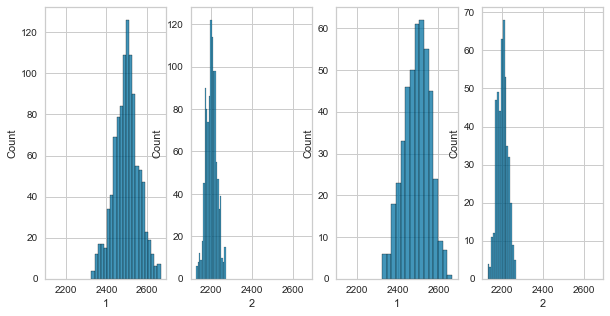

In [34]:
f, axes = plt.subplots(1,4, figsize=(10, 5), sharex=True)
sns.histplot(X_train['1'], ax=axes[0])
sns.histplot(X_train['2'], ax=axes[1])
sns.histplot(X_test['1'], ax=axes[2])
sns.histplot(X_test['2'], ax=axes[3])
plt.show()

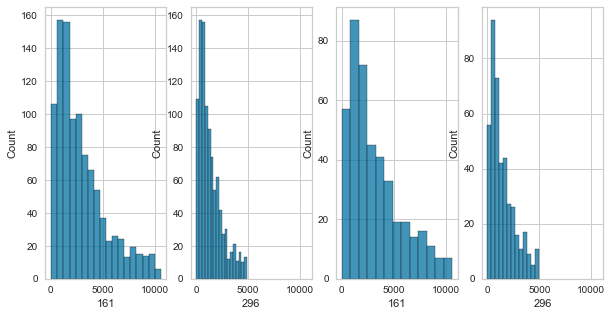

In [35]:
f, axes = plt.subplots(1,4, figsize=(10, 5), sharex=True)
sns.histplot(X_train['161'], ax=axes[0])
sns.histplot(X_train['296'], ax=axes[1])
sns.histplot(X_test['161'], ax=axes[2])
sns.histplot(X_test['296'], ax=axes[3])
plt.show()


Summary:
1. Data has been devided into 2 parts train and test
2. Checked for data distribution and possible variation
2. Based on Mean and standard deviation of the groupvariables 161 and 296 seems to have slight variation in distribution

### Step 4: Model training, testing and tuning:

In [36]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
scoring = ["accuracy", "balanced_accuracy"]

index = []
scores = {"Accuracy": [], "Balanced accuracy": []}

index += ["Dummy classifier"]
cv=RepeatedStratifiedKFold(n_splits=10, random_state=124)
cv_result = cross_validate(dummy_clf, X_train,y_train, scoring=scoring,cv=cv)

scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())


df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.933,0.500


### Pipileine 1 : Missing data Imputation+standardization+logistic Regresssion

In [37]:
steps=list()
from sklearn.impute import SimpleImputer, KNNImputer
from imblearn.pipeline import Pipeline

steps.append(('imputation',SimpleImputer(missing_values=np.nan, strategy='mean')))
steps.append(('stdsca',StandardScaler()))
steps.append(('model',LogisticRegression()))

pipeline1=Pipeline(steps)

index += ["Logistic classifier"]
cv=RepeatedStratifiedKFold(n_splits=10, random_state=124)
cv_result = cross_validate(pipeline1, X_train,y_train, scoring=scoring,cv=cv)

scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.933,0.500
Logistic classifier,0.885,0.551


### Pipileine 2 : Missing data Imputation+Over Sampling+standardization+logistic Regresssion

In [38]:
from imblearn.pipeline import Pipeline
steps_over_samp=list()
steps_over_samp.append(('imputation',SimpleImputer(missing_values=np.nan, strategy='mean')))
steps_over_samp.append(('over', RandomOverSampler()))
steps_over_samp.append(('stdsca',StandardScaler()))
steps_over_samp.append(('model',LogisticRegression(class_weight='balanced')))

pipeline2=Pipeline(steps_over_samp)

index += ["Logistic Oversampling"]
cv=RepeatedStratifiedKFold(n_splits=10, random_state=124)
cv_result = cross_validate(pipeline2, X_train,y_train, scoring=scoring,cv=cv)

scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.933,0.500
Logistic classifier,0.885,0.551
Logistic Oversampling,0.825,0.563


### Pipileine 3 : Missing data Imputation+under sampling+standardization+logistic Regresssion

In [39]:
from imblearn.pipeline import Pipeline
steps_Under_samp=list()
steps_Under_samp.append(('imputation',SimpleImputer(missing_values=np.nan, strategy='mean')))
steps_Under_samp.append(('under', RandomUnderSampler()))
steps_Under_samp.append(('stdsca',StandardScaler()))
steps_Under_samp.append(('model',LogisticRegression(class_weight='balanced')))

pipeline3=Pipeline(steps_Under_samp)

index += ["Logistic Undersampling"]
cv=RepeatedStratifiedKFold(n_splits=10, random_state=124)
cv_result = cross_validate(pipeline3, X_train,y_train, scoring=scoring,cv=cv)

scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.933,0.500
Logistic classifier,0.885,0.551
Logistic Oversampling,0.825,0.563
Logistic Undersampling,0.566,0.573


### Pipileine 4 : Missing data Imputation+under sampling+pca+standardization+logistic Regresssion

In [40]:
from imblearn.pipeline import Pipeline
steps_Under_samp=list()
steps_Under_samp.append(('imputation',SimpleImputer(missing_values=np.nan, strategy='mean')))
steps_Under_samp.append(('under', RandomUnderSampler()))
steps_Under_samp.append(('stdsca',StandardScaler()))
steps_Under_samp.append(('pca',PCA(0.95)))
steps_Under_samp.append(('model',LogisticRegression(class_weight='balanced')))

pipeline4=Pipeline(steps_Under_samp)

index += ["Logistic Undersampling PCA"]
cv=RepeatedStratifiedKFold(n_splits=10, random_state=124)
cv_result = cross_validate(pipeline4, X_train,y_train, scoring=scoring,cv=cv)

scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.933,0.500
Logistic classifier,0.885,0.551
Logistic Oversampling,0.825,0.563
Logistic Undersampling,0.566,0.573
Logistic Undersampling PCA,0.556,0.557


In [41]:
X_train1=X_train[var_sig]
steps_over_samp=list()
steps_over_samp.append(('imputation',SimpleImputer(missing_values=np.nan, strategy='mean')))
steps_over_samp.append(('over', RandomOverSampler()))
steps_over_samp.append(('stdsca',StandardScaler()))
steps_over_samp.append(('model',LogisticRegression(class_weight='balanced')))

pipeline5=Pipeline(steps_over_samp)

index += ["Logistic Oversampling sel var"]
cv=RepeatedStratifiedKFold(n_splits=10, random_state=124)
cv_result = cross_validate(pipeline5, X_train1,y_train, scoring=scoring,cv=cv)

scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.933,0.500
Logistic classifier,0.885,0.551
Logistic Oversampling,0.825,0.563
Logistic Undersampling,0.566,0.573
Logistic Undersampling PCA,0.556,0.557
Logistic Oversampling sel var,0.727,0.610


In [42]:
X_train1=X_train[var_sig]

steps_over_samp=list()
steps_over_samp.append(('imputation',SimpleImputer(missing_values=np.nan, strategy='mean')))
steps_over_samp.append(('over', RandomOverSampler()))
steps_over_samp.append(('stdsca',StandardScaler()))
steps_over_samp.append(('pca',PCA(0.95)))
steps_over_samp.append(('model',LogisticRegression(class_weight='balanced')))

pipeline6=Pipeline(steps_over_samp)

index += ["Logistic Oversampling PCA sel var"]
cv=RepeatedStratifiedKFold(n_splits=10, random_state=124)
cv_result = cross_validate(pipeline6, X_train1,y_train, scoring=scoring,cv=cv)

scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.933,0.500
Logistic classifier,0.885,0.551
Logistic Oversampling,0.825,0.563
Logistic Undersampling,0.566,0.573
Logistic Undersampling PCA,0.556,0.557
Logistic Oversampling sel var,0.727,0.610
Logistic Oversampling PCA sel var,0.711,0.624


### Pipileine 4 : Missing data Imputation+over sampling+standardization+sig_feature+logistic Regresssion

In [43]:
param_grid = {'model__solver':['newton-cg', 'lbfgs', 'liblinear'],
              'model__penalty': ['l2','l1'],
              'model__C': [100, 10, 1.0, 0.1, 0.01]} 
grid =  RandomizedSearchCV(pipeline6, param_distributions = param_grid, n_iter = 10)  
# grid =  RandomizedSearchCV(pipeline_os_pca , param_distributions = param_grid, n_iter = 10,cv=cv,scoring='f1_micro') 

grid.fit( X_train, y_train) 

print(" Best cross-validation accuracy: {:.2f}". format( grid.best_score_)) 
print(" Best parameters: ", grid.best_params_) 
print(" Test set accuracy: {:.2f}". format( grid.score( X_test, y_test)))

 Best cross-validation accuracy: 0.81
 Best parameters:  {'model__solver': 'lbfgs', 'model__penalty': 'l2', 'model__C': 10}
 Test set accuracy: 0.76


In [44]:
X_train1=X_train[var_sig]

steps_over_samp=list()
steps_over_samp.append(('imputation',SimpleImputer(missing_values=np.nan, strategy='mean')))
steps_over_samp.append(('over', RandomOverSampler()))
steps_over_samp.append(('stdsca',StandardScaler()))
steps_over_samp.append(('pca',PCA(0.95)))
steps_over_samp.append(('model',LogisticRegression(class_weight='balanced',solver='lbfgs',penalty='l2', C=1)))

pipeline7=Pipeline(steps_over_samp)

index += ["Logistic hypertune Oversampling PCA sel var"]
cv=RepeatedStratifiedKFold(n_splits=10, random_state=124)
cv_result = cross_validate(pipeline7, X_train1,y_train, scoring=scoring,cv=cv)

scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.933,0.500
Logistic classifier,0.885,0.551
Logistic Oversampling,0.825,0.563
Logistic Undersampling,0.566,0.573
Logistic Undersampling PCA,0.556,0.557
Logistic Oversampling sel var,0.727,0.610
Logistic Oversampling PCA sel var,0.711,0.624
Logistic hypertune Oversampling PCA sel var,0.711,0.626


### Pipileine 4 : Missing data Imputation+over sampling+standardization+sig_feature+logistic Regresssion with hypertune parameter

In [45]:
from imblearn.pipeline import Pipeline
steps_Under_samp=list()
steps_Under_samp.append(('imputation',SimpleImputer(missing_values=np.nan, strategy='mean')))
steps_Under_samp.append(('under', RandomUnderSampler()))
steps_Under_samp.append(('stdsca',StandardScaler()))
steps_Under_samp.append(('model',LogisticRegression(class_weight='balanced',solver='lbfgs',penalty='l2', C=1)))

pipeline8=Pipeline(steps_Under_samp)

index += ["Logistic hypertune Undersampling PCA"]
cv=RepeatedStratifiedKFold(n_splits=10, random_state=124)
cv_result = cross_validate(pipeline8, X_train,y_train, scoring=scoring,cv=cv)

scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.933,0.500
Logistic classifier,0.885,0.551
Logistic Oversampling,0.825,0.563
Logistic Undersampling,0.566,0.573
Logistic Undersampling PCA,0.556,0.557
Logistic Oversampling sel var,0.727,0.610
Logistic Oversampling PCA sel var,0.711,0.624
Logistic hypertune Oversampling PCA sel var,0.711,0.626
Logistic hypertune Undersampling PCA,0.562,0.563


### interation 6: Randomforest

In [46]:
from imblearn.ensemble import BalancedRandomForestClassifier
steps_rf=list()
steps_rf.append(('imputation',SimpleImputer(missing_values=np.nan, strategy='mean')))
steps_rf.append(('stdsca',StandardScaler()))
steps_rf.append(('model',BalancedRandomForestClassifier()))

pipeline9=Pipeline(steps_rf)

index += ["Random Forest"]
cv_result = cross_validate(pipeline9, X_train,y_train, scoring=scoring,cv=cv)

scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.933,0.500
Logistic classifier,0.885,0.551
Logistic Oversampling,0.825,0.563
Logistic Undersampling,0.566,0.573
Logistic Undersampling PCA,0.556,0.557
Logistic Oversampling sel var,0.727,0.610
Logistic Oversampling PCA sel var,0.711,0.624
Logistic hypertune Oversampling PCA sel var,0.711,0.626
Logistic hypertune Undersampling PCA,0.562,0.563
Random Forest,0.628,0.600


## iteration 7: Randomforest+PCA

In [47]:
from imblearn.ensemble import BalancedRandomForestClassifier
steps_rf=list()
steps_rf.append(('imputation',SimpleImputer(missing_values=np.nan, strategy='mean')))
steps_rf.append(('stdsca',StandardScaler()))
steps_rf.append(('pca',PCA(0.95)))
steps_rf.append(('model',BalancedRandomForestClassifier()))

pipeline10=Pipeline(steps_rf)

index += ["Random Forest pca"]
cv_result = cross_validate(pipeline10, X_train,y_train, scoring=scoring,cv=cv)

scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.933,0.500
Logistic classifier,0.885,0.551
Logistic Oversampling,0.825,0.563
Logistic Undersampling,0.566,0.573
Logistic Undersampling PCA,0.556,0.557
Logistic Oversampling sel var,0.727,0.610
Logistic Oversampling PCA sel var,0.711,0.624
Logistic hypertune Oversampling PCA sel var,0.711,0.626
Logistic hypertune Undersampling PCA,0.562,0.563
Random Forest,0.628,0.600


In [48]:
from imblearn.pipeline import Pipeline
steps_Under_samp=list()
steps_Under_samp.append(('imputation',SimpleImputer(missing_values=np.nan, strategy='mean')))
steps_Under_samp.append(('under', RandomUnderSampler()))
steps_Under_samp.append(('stdsca',StandardScaler()))
steps_Under_samp.append(('model',BalancedRandomForestClassifier(class_weight="balanced")))

pipeline11=Pipeline(steps_Under_samp)

index += ["Random Forest under sampling"]
cv_result = cross_validate(pipeline11, X_train,y_train, scoring=scoring,cv=cv)

scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.933,0.500
Logistic classifier,0.885,0.551
Logistic Oversampling,0.825,0.563
Logistic Undersampling,0.566,0.573
Logistic Undersampling PCA,0.556,0.557
Logistic Oversampling sel var,0.727,0.610
Logistic Oversampling PCA sel var,0.711,0.624
Logistic hypertune Oversampling PCA sel var,0.711,0.626
Logistic hypertune Undersampling PCA,0.562,0.563
Random Forest,0.628,0.600


In [49]:
X_train1.shape

(1096, 58)

In [50]:
from imblearn.pipeline import Pipeline
steps_Under_samp=list()
steps_Under_samp.append(('imputation',SimpleImputer(missing_values=np.nan, strategy='mean')))
steps_Under_samp.append(('under', RandomUnderSampler()))
steps_Under_samp.append(('stdsca',StandardScaler()))
steps_Under_samp.append(('model',BalancedRandomForestClassifier(class_weight="balanced")))

pipeline12=Pipeline(steps_Under_samp)


index += ["Random Forest under sampling sel_var"]
cv_result = cross_validate(pipeline12, X_train1,y_train, scoring=scoring,cv=cv)

scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.933,0.500
Logistic classifier,0.885,0.551
Logistic Oversampling,0.825,0.563
Logistic Undersampling,0.566,0.573
Logistic Undersampling PCA,0.556,0.557
Logistic Oversampling sel var,0.727,0.610
Logistic Oversampling PCA sel var,0.711,0.624
Logistic hypertune Oversampling PCA sel var,0.711,0.626
Logistic hypertune Undersampling PCA,0.562,0.563
Random Forest,0.628,0.600


In [51]:
steps_Under_samp=list()
steps_Under_samp.append(('imputation',SimpleImputer(missing_values=np.nan, strategy='mean')))
steps_Under_samp.append(('under', RandomUnderSampler()))
steps_Under_samp.append(('stdsca',StandardScaler()))
steps_Under_samp.append(('pca',PCA(0.95)))
steps_Under_samp.append(('model',BalancedRandomForestClassifier(class_weight="balanced")))

pipeline13=Pipeline(steps_Under_samp)

index += ["Random Forest under sampling pca"]
cv_result = cross_validate(pipeline13, X_train,y_train, scoring=scoring,cv=cv)

scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.933,0.500
Logistic classifier,0.885,0.551
Logistic Oversampling,0.825,0.563
Logistic Undersampling,0.566,0.573
Logistic Undersampling PCA,0.556,0.557
Logistic Oversampling sel var,0.727,0.610
Logistic Oversampling PCA sel var,0.711,0.624
Logistic hypertune Oversampling PCA sel var,0.711,0.626
Logistic hypertune Undersampling PCA,0.562,0.563
Random Forest,0.628,0.600


In [52]:
BalancedRandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'replacement', 'sampling_strategy', 'verbose', 'warm_start'])

In [53]:
random_forest= BalancedRandomForestClassifier()
parms={
      "model__n_estimators":[50,150],
      "model__max_features":[5,'auto'],
      "model__min_samples_leaf":[2,3,5],
      "model__class_weight":[ "balanced", "balanced_subsample"]
            
      }
cv= GridSearchCV(pipeline9,parms, n_jobs=-1,scoring="balanced_accuracy").fit(X_train,y_train) #n_jobs to allow parralel processsing
print(cv.best_params_)

max_features=cv.best_params_['model__max_features']
min_samples_leaf=cv.best_params_['model__min_samples_leaf']
n_estimators=cv.best_params_['model__n_estimators']
class_weight=cv.best_params_['model__class_weight']


{'model__class_weight': 'balanced', 'model__max_features': 'auto', 'model__min_samples_leaf': 2, 'model__n_estimators': 150}


In [54]:
steps_Under_samp=list()
steps_Under_samp.append(('imputation',SimpleImputer(missing_values=np.nan, strategy='mean')))
steps_Under_samp.append(('under', RandomUnderSampler()))
steps_Under_samp.append(('stdsca',StandardScaler()))
steps_Under_samp.append(('model',BalancedRandomForestClassifier(class_weight="balanced_subsample",
                                                                max_features= 'auto', 
                                                                min_samples_leaf=2, 
                                                                n_estimators=150)))
pipeline14=Pipeline(steps_Under_samp)

index += ["Random Forest hypertuned under sampling"]
cv=RepeatedStratifiedKFold(n_splits=10, random_state=124)
cv_result = cross_validate(pipeline14, X_train,y_train, scoring=scoring,cv=cv)

scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.933,0.500
Logistic classifier,0.885,0.551
Logistic Oversampling,0.825,0.563
Logistic Undersampling,0.566,0.573
Logistic Undersampling PCA,0.556,0.557
Logistic Oversampling sel var,0.727,0.610
Logistic Oversampling PCA sel var,0.711,0.624
Logistic hypertune Oversampling PCA sel var,0.711,0.626
Logistic hypertune Undersampling PCA,0.562,0.563
Random Forest,0.628,0.600


In [55]:
steps_Under_samp=list()
steps_Under_samp.append(('imputation',SimpleImputer(missing_values=np.nan, strategy='mean')))
#steps_Under_samp.append(('under', RandomUnderSampler()))
steps_Under_samp.append(('stdsca',StandardScaler()))
steps_Under_samp.append(('model',BalancedRandomForestClassifier(class_weight="balanced_subsample",
                                                                max_features= 'auto', 
                                                                min_samples_leaf=2, 
                                                                n_estimators=150)))

pipeline15=Pipeline(steps_Under_samp)

index += ["Random Forest hypertuned"]
cv_result = cross_validate(pipeline15, X_train,y_train, scoring=scoring,cv=cv)

scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.933,0.500
Logistic classifier,0.885,0.551
Logistic Oversampling,0.825,0.563
Logistic Undersampling,0.566,0.573
Logistic Undersampling PCA,0.556,0.557
Logistic Oversampling sel var,0.727,0.610
Logistic Oversampling PCA sel var,0.711,0.624
Logistic hypertune Oversampling PCA sel var,0.711,0.626
Logistic hypertune Undersampling PCA,0.562,0.563
Random Forest,0.628,0.600


In [56]:
steps_Under_samp=list()
steps_Under_samp.append(('imputation',SimpleImputer(missing_values=np.nan, strategy='mean')))
#steps_Under_samp.append(('under', RandomUnderSampler()))
steps_Under_samp.append(('stdsca',StandardScaler()))
steps_Under_samp.append(('model',BalancedRandomForestClassifier(class_weight="balanced_subsample",
                                                                max_features= 5, 
                                                                min_samples_leaf=5, 
                                                                n_estimators=150)))

pipeline16=Pipeline(steps_Under_samp)

index += ["Random Forest hypertuned selvar"]
cv_result = cross_validate(pipeline16, X_train1,y_train, scoring=scoring,cv=cv)

scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.933,0.500
Logistic classifier,0.885,0.551
Logistic Oversampling,0.825,0.563
Logistic Undersampling,0.566,0.573
Logistic Undersampling PCA,0.556,0.557
Logistic Oversampling sel var,0.727,0.610
Logistic Oversampling PCA sel var,0.711,0.624
Logistic hypertune Oversampling PCA sel var,0.711,0.626
Logistic hypertune Undersampling PCA,0.562,0.563
Random Forest,0.628,0.600


In [57]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.ensemble import BalancedBaggingClassifier

In [58]:
steps_1=list()
steps_1.append(('imputation',SimpleImputer(missing_values=np.nan, strategy='mean')))
steps_1.append(('under', RandomUnderSampler()))
steps_1.append(('stdsca',StandardScaler()))
steps_1.append(('model', BalancedBaggingClassifier(
                                                   base_estimator=HistGradientBoostingClassifier(random_state=42),
                                                n_estimators=10,
                                                    random_state=42,
                                                 n_jobs=2)))

pipeline17=Pipeline(steps_1)

index += ["Gradient Boosting"]
cv_result = cross_validate(pipeline17, X_train1,y_train, scoring=scoring,cv=cv)

scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.933,0.500
Logistic classifier,0.885,0.551
Logistic Oversampling,0.825,0.563
Logistic Undersampling,0.566,0.573
Logistic Undersampling PCA,0.556,0.557
Logistic Oversampling sel var,0.727,0.610
Logistic Oversampling PCA sel var,0.711,0.624
Logistic hypertune Oversampling PCA sel var,0.711,0.626
Logistic hypertune Undersampling PCA,0.562,0.563
Random Forest,0.628,0.600


In [80]:
# ## Compairing best perfomance models from each iterations
classifier1 = pipeline12
classifier2 = pipeline7
classifier3 = pipeline17
classifier4 = pipeline16

probas1_ = cross_val_predict(classifier1,X_test, y_test, cv=3,method='predict_proba')
probas2_ = cross_val_predict(classifier2,X_test, y_test, cv=3,method='predict_proba')
probas3_ = cross_val_predict(classifier3,X_test, y_test, cv=3,method='predict_proba')
probas4_ = cross_val_predict(classifier4,X_test, y_test, cv=3,method='predict_proba')

In [81]:
#### getting roc_auc
fpr1, tpr1, thresholds1 = roc_curve(y_test, probas1_[:, 1])
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, thresholds2 = roc_curve(y_test, probas2_[:, 1])
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, thresholds3 = roc_curve(y_test, probas3_[:, 1])
roc_auc3 = auc(fpr3, tpr3)

fpr4, tpr4, thresholds4 = roc_curve(y_test, probas4_[:, 1])
roc_auc4 = auc(fpr4, tpr4)

In [87]:
tpr1

array([0.        , 0.        , 0.03225806, 0.03225806, 0.06451613,
       0.06451613, 0.06451613, 0.09677419, 0.09677419, 0.09677419,
       0.16129032, 0.16129032, 0.16129032, 0.19354839, 0.22580645,
       0.29032258, 0.29032258, 0.32258065, 0.32258065, 0.35483871,
       0.38709677, 0.38709677, 0.41935484, 0.51612903, 0.5483871 ,
       0.61290323, 0.64516129, 0.70967742, 0.77419355, 0.77419355,
       0.77419355, 0.77419355, 0.80645161, 0.83870968, 0.87096774,
       0.93548387, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [61]:
import pylab as pl

<Figure size 432x288 with 0 Axes>

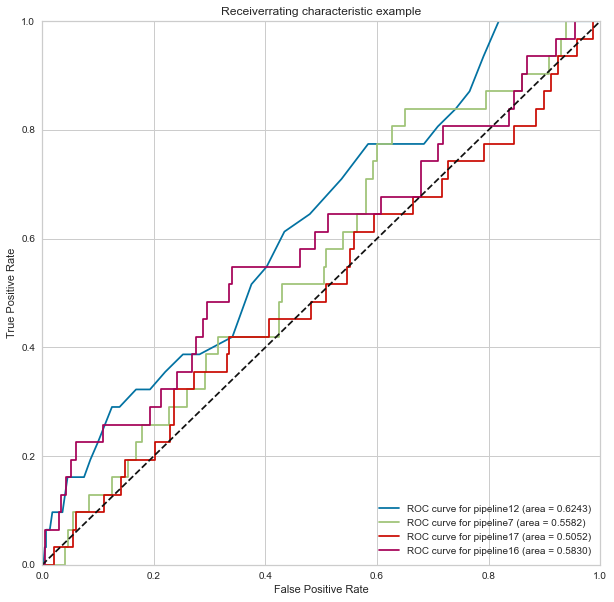

In [82]:
#Plot ROC curve
pl.clf()
plt.figure(figsize=(10,10))
pl.plot(fpr1, tpr1, label='ROC curve for pipeline12 (area = %0.4f)' % roc_auc1)
pl.plot(fpr2, tpr2, label='ROC curve for pipeline7 (area = %0.4f)' % roc_auc2)
pl.plot(fpr3, tpr3, label='ROC curve for pipeline17 (area = %0.4f)' % roc_auc3)
pl.plot(fpr4, tpr4, label='ROC curve for pipeline16 (area = %0.4f)' % roc_auc4)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiverrating characteristic example')
pl.legend(loc="lower right")
pl.show()

In [83]:
# save the model to disk
import pickle
filename = 'pipeline12'
pickle.dump(pipeline12, open(filename, 'wb'))

Summary:
1. Model has been used on train data.
2. Target variable is imbalanced
3. pipeline has been used for all model training.
4. all the pipeline has regular steps like, imputation, standardscaling which has been used on cross validation data.
5. to take car of imbalanced target imblearn pipeline has been used, as this allows to oursample/undersample data at K-fold validation.
6. Have tried various combination of Logistic regession, PCA, Balanced Random Forest, balnace bagging and gridsearch.
7. This data suffers from curse of demintionality.
8. This data is high demention data, but does not have enough quantity of data to build model.
9. Random forest classifier has shown biased toward majority class.
10. So tried Balanced Random forest algorithm, which is able to classifiy pass and Fail
11. Tried various algorithm, SVM, NB, Logistic and Random Forest., boosting. 
12. Logistic has shown ability to classify data points, but needs more data for learning as data has high dementions and imbalance class
13. Based on ROC_AUC curveand Recall chose a model with Balanced Random forest which uses undersampling for classification

In [85]:
data2.describe()

,0,14,21,28,33,35,59,64,65,68,90,122,133,135,152,155,159,160,180,183,188,197,200,205,207,270,287,294,295,316,319,333,336,341,343,408,416,417,420,423,425,428,430,431,434,452,453,455,460,468,469,477,479,484,488,510,511,545
count,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000,18.000
mean,3000.383,10.438,-5018.139,64.336,9.065,64.149,13.810,18.412,25.567,147.609,8714.983,2.806,996.653,102.833,0.684,1.118,2220.056,1065.278,17.147,25.942,54.576,18.883,14.180,10.822,18.632,28.311,0.206,1092.599,508.338,5.368,7.670,5.722,9.068,3.247,5.588,4.650,3.097,6.548,2.655,73.345,7.052,9.898,69.640,69.495,59.315,4.791,4.477,3.491,28.464,89.983,5.267,7.347,2.961,250.891,288.815,116.258,176.862,7.116
std,49.609,1.684,1354.174,2.742,0.420,0.152,14.969,6.017,7.412,3.522,428.396,0.363,5.770,18.102,0.363,2.893,2044.769,1089.298,2.562,7.725,20.520,3.520,4.131,4.710,7.242,4.301,0.110,1088.142,565.303,0.627,2.121,0.758,1.182,1.138,2.067,0.801,0.510,1.537,0.733,25.199,3.761,27.170,105.447,108.571,108.617,0.738,1.654,0.989,8.344,132.300,0.964,3.234,1.126,331.770,248.460,58.846,279.594,0.000
min,2920.070,7.956,-6154.000,60.244,8.576,63.829,-12.294,10.869,15.309,142.516,7869.700,2.270,980.451,70.000,0.351,0.350,233.000,59.000,12.480,15.840,11.961,12.560,5.580,6.230,8.020,19.095,0.103,106.497,26.588,4.382,5.168,4.460,7.742,1.928,2.489,3.127,2.258,4.218,1.458,44.960,3.375,2.805,4.318,2.265,3.429,3.477,2.133,2.189,8.949,8.292,3.459,4.148,1.293,0.000,0.000,55.026,0.000,7.116
25%,2964.898,9.210,-5721.062,62.575,8.691,64.097,-0.693,13.495,20.381,144.621,8502.547,2.550,993.127,89.250,0.446,0.403,739.000,346.000,15.120,20.517,39.847,15.988,11.745,7.297,12.985,24.498,0.130,327.862,147.387,4.920,6.263,5.139,8.172,2.426,3.837,4.078,2.771,5.405,2.040,54.543,4.338,3.235,13.500,12.087,8.094,4.213,3.372,2.748,22.539,19.491,4.474,4.999,2.124,0.000,121.230,71.332,0.000,7.116
50%,3005.080,9.884,-5458.000,63.367,8.963,64.132,21.522,17.633,24.542,146.902,8730.715,2.771,997.769,96.500,0.524,0.465,1335.000,645.500,17.000,23.139,53.252,19.575,13.915,9.325,17.650,29.228,0.155,588.844,271.699,5.244,6.833,5.826,8.726,3.058,5.573,4.330,3.026,6.184,2.484,61.939,5.645,3.719,24.110,23.279,9.247,4.674,4.066,3.179,30.118,23.822,5.459,6.336,2.831,62.157,202.415,92.279,0.000,7.116
75%,3031.912,12.100,-5367.000,67.108,9.435,64.241,26.505,21.593,28.012,150.184,9079.080,3.144,998.461,123.000,0.764,0.480,2397.750,952.750,19.020,34.643,71.772,20.572,17.113,12.672,21.845,30.982,0.271,1079.456,396.920,5.707,9.944,6.279,9.684,3.756,6.949,5.571,3.461,7.612,3.425,88.050,7.838,3.832,39.459,32.569,13.719,5.288,5.148,4.641,33.680,77.647,5.725,8.730,3.490,478.544,389.612,140.723,357.539,7.116
max,3095.780,13.687,-1431.500,68.711,9.800,64.402,29.131,32.294,44.150,154.371,9317.170,3.263,1004.805,127.000,1.389,12.710,5803.000,3530.000,21.300,37.715,82.986,24.700,21.780,24.970,34.990,34.125,0.413,3153.676,1768.641,6.551,11.058,6.902,11.551,6.276,9.585,5.636,3.930,9.060,3.696,141.651,14.315,118.753,400.000,400.000,400.000,6.083,7.542,4.994,42.826,463.288,6.859,16.970,5.506,981.432,748.178,263.454,748.387,7.116


## out of sample Prediction

In [102]:
pipeline12.fit(X_train1,y_train)
outputofsample_predict=pipeline12.predict(data2)
outputofsample_predict

array([-1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,
       -1], dtype=int64)

In [100]:
# load the model from disk
loaded_model = pickle.load(open('pipeline12', 'rb'))
result = loaded_model.predict(data2)
print(result)

[ 1 -1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1 -1 -1]


In [101]:
len(result)

18

In [92]:
# mis_impute=SimpleImputer(missing_values=np.nan, strategy='mean')
# x_train_imp= pd.DataFrame(mis_impute.fit_transform(data2), columns=data2.columns)

# train_scaled = scaler.transform(x_train_imp)
# x_imp=pd.DataFrame(train_scaled, columns=x_train_imp.columns)



In [94]:
outputofsample_predict-result

array([-2,  0,  0,  0,  0,  0,  0, -2,  0,  0,  0,  0,  0, -2,  0,  0,  0,
        0], dtype=int64)